In [1]:
from main_experiment_64 import *
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.path.insert(0, "../..")
import pytorch_ssim
plt.rcParams['figure.figsize'] = (60, 20)
%matplotlib inline

In [2]:
batch_size = 64

In [3]:
encoder = Encoder(1, gf_dim=16)
decoder = Decoder(1, gf_dim=16)

encoder = encoder.to(device())
decoder = decoder.to(device())

load_path = 'trained_models/vol_64_lr_0.001_kl_0.2__bsize_128/model_00000155.pth.tar'

print('Cuda is {}available'.format('' if torch.cuda.is_available() else 'not '))

checkpoint = torch.load(load_path, map_location=device())
start_epoch = checkpoint['epoch']
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
step = checkpoint['step']
print("=> loaded")

print(encoder)
print(decoder)
encoder = encoder.to(device())
decoder = decoder.to(device())
train_loader = make_train_loader(batch_size=batch_size)
test_loader = make_test_loader(batch_size=batch_size)


Cuda is not available
=> loaded
Encoder(
  (conv1_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (res1): ResBlockDown(
    (conv1_block): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv2_block): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3_block): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (lrelu): Lea

In [4]:
def plot_sequence_coronal(data, K=10):
    plt.rcParams['figure.figsize'] = (30, 10)
    mask_ix = sorted(list(set(np.linspace(0, batch_size - 1, K).astype(np.int))))
    mask = [True if i in mask_ix else False for i in range(batch_size)]
    if type(data) is torch.Tensor:
        data = data.detach().numpy()
    for i, mix in enumerate(mask_ix):
        plt.subplot(1, K, i+1)
        plt.imshow(data[mix, 0, :, :].squeeze(), vmin=0.0, vmax=1.0, cmap='gray')
        plt.axis('off')
    plt.show()

In [5]:
def plot_sequence_sagittal(data, K=10):
    plt.rcParams['figure.figsize'] = (30, 10)
    mask_ix = sorted(list(set(np.linspace(0, batch_size - 1, K).astype(np.int))))
    mask = [True if i in mask_ix else False for i in range(batch_size)]
    if type(data) is torch.Tensor:
        data = data.detach().numpy()
    for i, mix in enumerate(mask_ix):
        plt.subplot(1, K, i+1)
        plt.imshow(data[:, 0, mix, :].squeeze(), vmin=0.0, vmax=1.0, cmap='gray')
        plt.axis('off')
    plt.show()

In [6]:
def plot_sequence_axial(data, K=10):
    plt.rcParams['figure.figsize'] = (30, 10)
    mask_ix = sorted(list(set(np.linspace(0, batch_size - 1, K).astype(np.int))))
    mask = [True if i in mask_ix else False for i in range(batch_size)]
    if type(data) is torch.Tensor:
        data = data.detach().numpy()
    for i, mix in enumerate(mask_ix):
        plt.subplot(1, K, i+1)
        plt.imshow(data[:, 0, :, mix].squeeze(), vmin=0.0, vmax=1.0, cmap='gray')
        plt.axis('off')
    plt.show()

In [8]:
AXIS=32
conv_h, conv_w = 2,2
latent_dimension = 8*32
img_size=64

In [9]:
N_train_ex = 400
latents_train = np.zeros((N_train_ex, batch_size, latent_dimension, conv_h, conv_w))
for i, (data, _) in enumerate(train_loader):
    data = data.to(device())
    if i == N_train_ex:
        break
    latent, mu, std = encoder(data)
    latents_train[i, ...] = mu.cpu().detach().numpy()


In [10]:
N_test_ex = 20
latents_test = np.zeros((N_test_ex, batch_size, latent_dimension, conv_h, conv_w))
images_test = np.zeros((N_test_ex, batch_size, img_size, img_size))
for i, (data, _) in enumerate(test_loader):
    if i == N_test_ex:
        break
    data = data.to(device())
    latent, mu, std  = encoder(data)
    latents_test[i, ...] = mu.cpu().detach().numpy()
    images_test[i, ...] = data.cpu().squeeze().detach().numpy()

In [11]:
def flatten_conv_map(latent):
    return latent.reshape([latent.shape[0], latent.shape[1], -1])

In [12]:
def unflatten_conv_map(flattened):
    return flattened.reshape([flattened.shape[0], flattened.shape[1], latent_dimension, conv_h, conv_w])

# Data

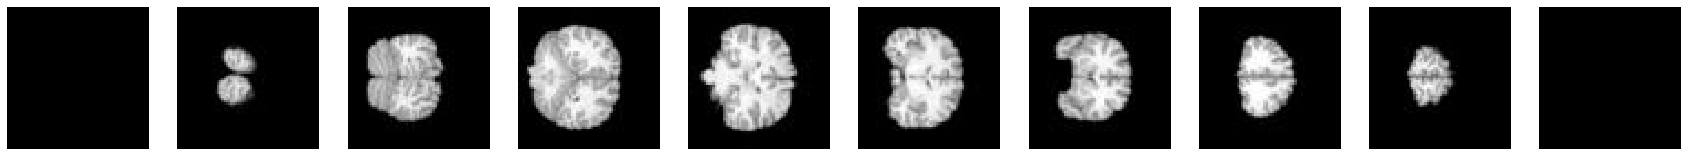

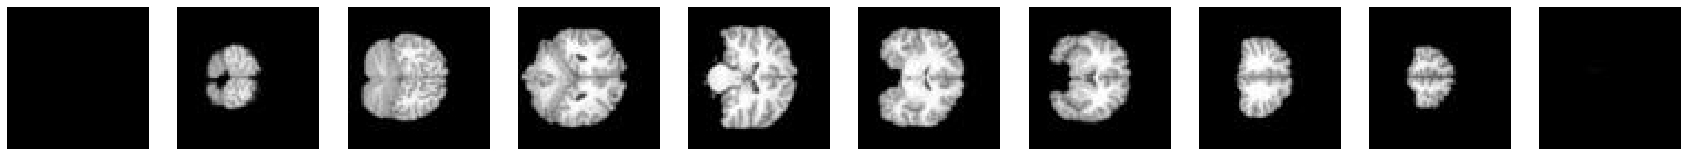

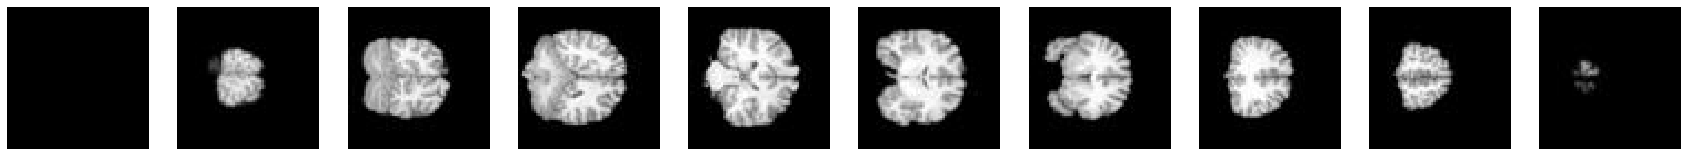

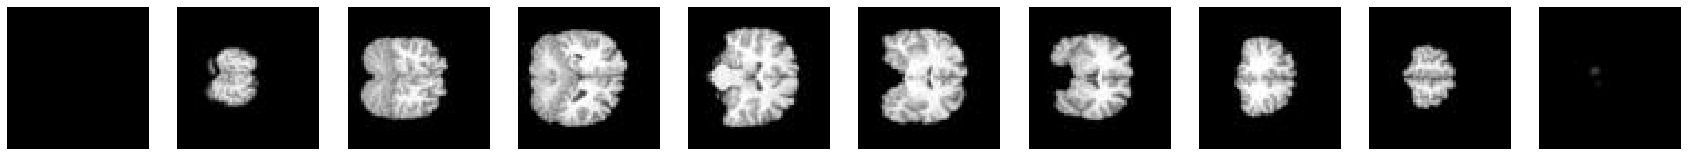

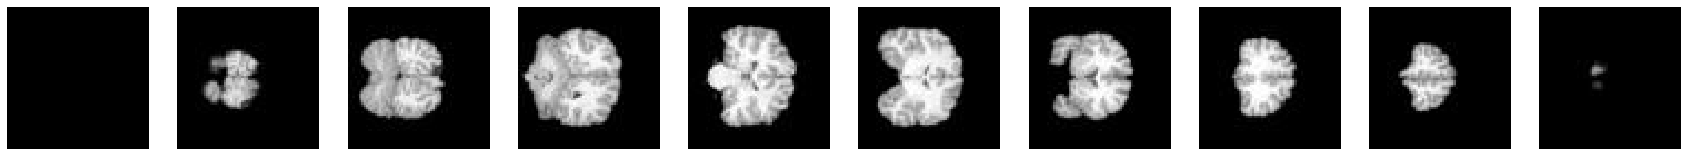

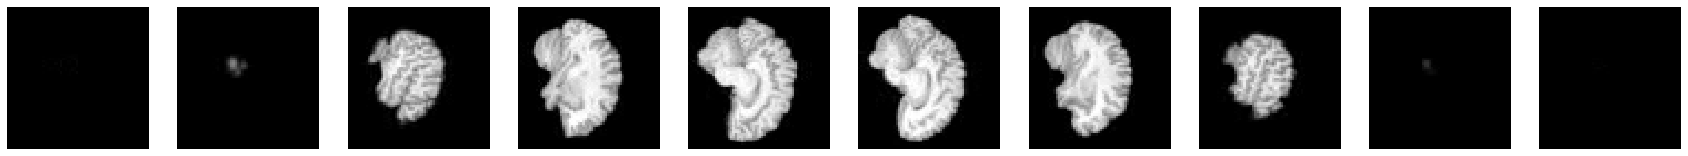

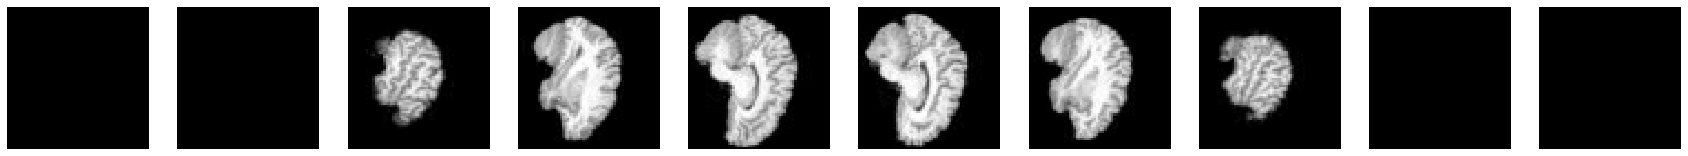

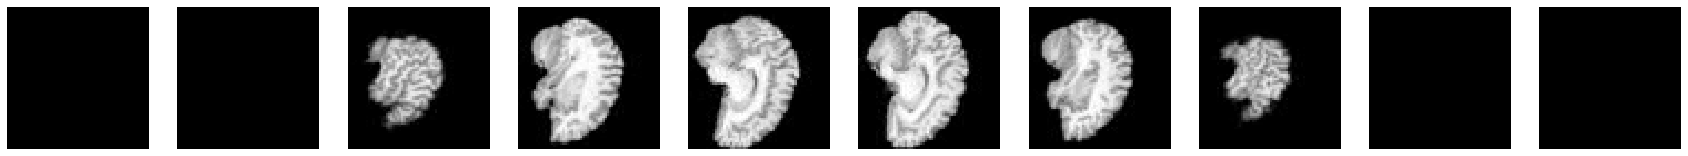

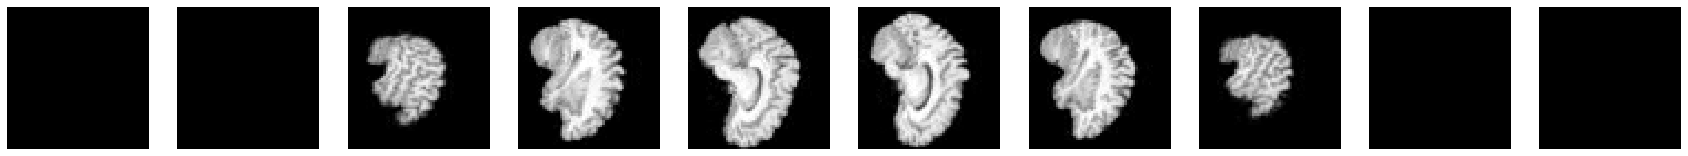

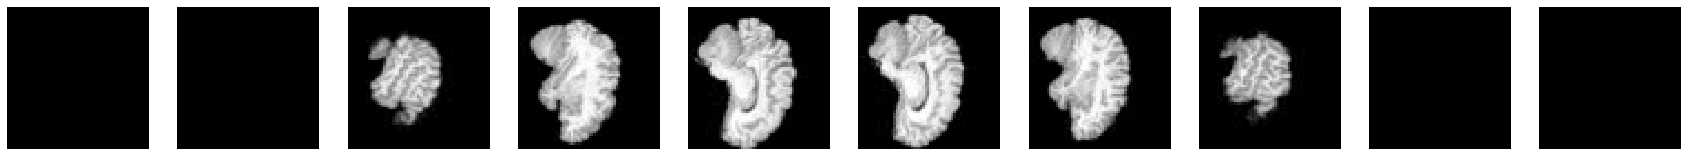

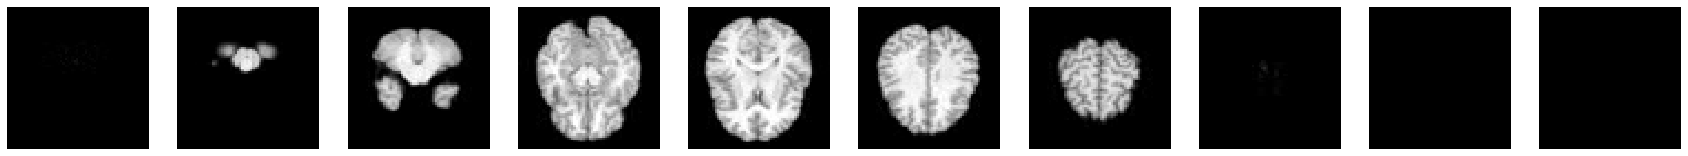

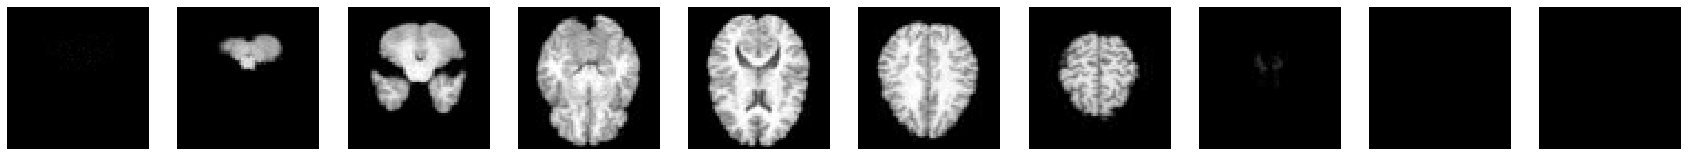

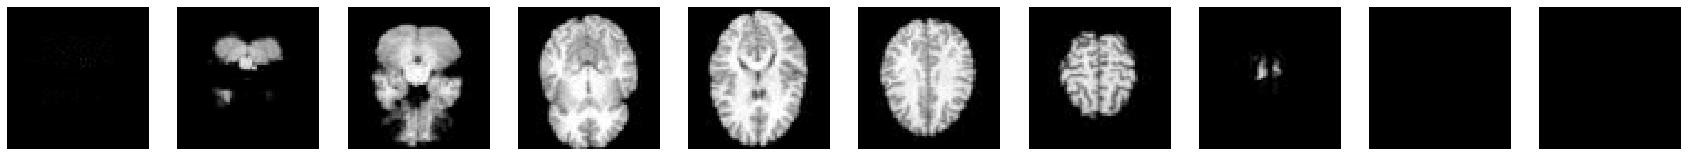

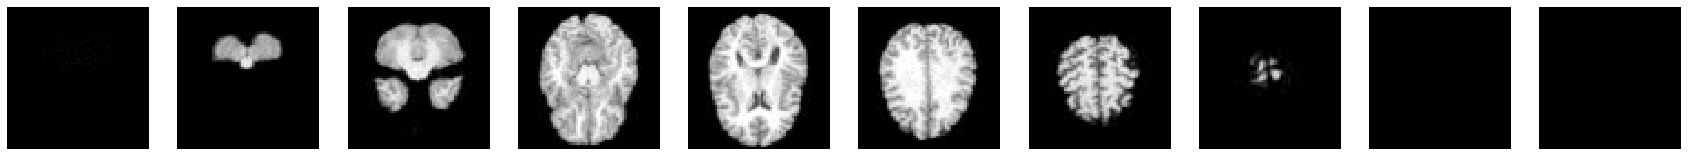

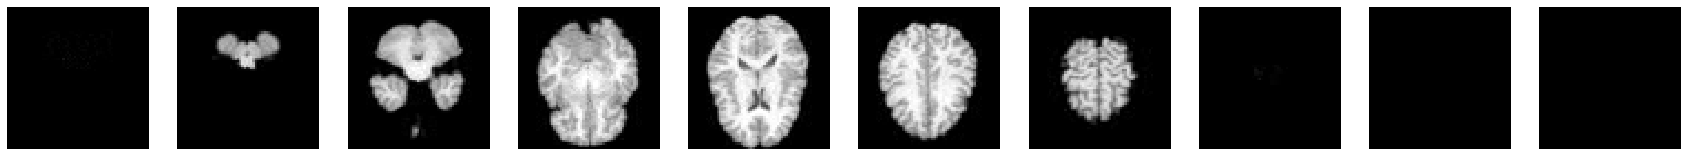

In [13]:
for i in range(5):
    images = images_test[i, :, None, :, :]
    plot_sequence_coronal(images, K=10)
print('='*80)
for i in range(5):
    images = images_test[i, :, None, :, :]
    plot_sequence_sagittal(images, K=10)
print('='*80)
for i in range(5):
    images = images_test[i, :, None, :, :]
    plot_sequence_axial(images, K=10)

# Samples from Gaussian Model

In [14]:
flattened_latents_train = flatten_conv_map(latents_train)
flattened_latents_test = flatten_conv_map(latents_test)

mean = flattened_latents_train.transpose(-1, 0, 1).mean(axis=1, keepdims=True)
X = flattened_latents_train.transpose(-1, 0, 1) - mean
X_test = flattened_latents_test.transpose(-1, 0, 1) - mean
    
u, s, vh = np.linalg.svd(X)


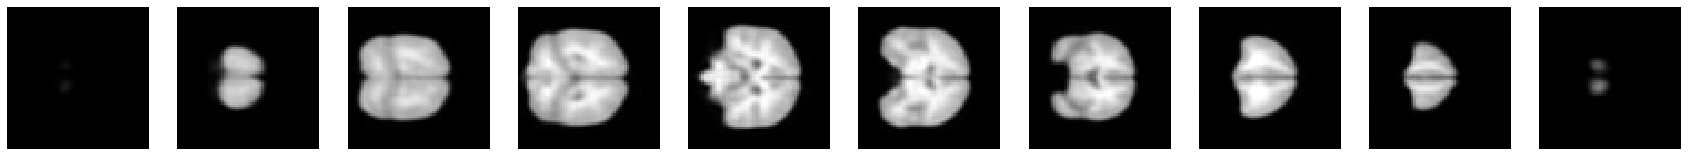

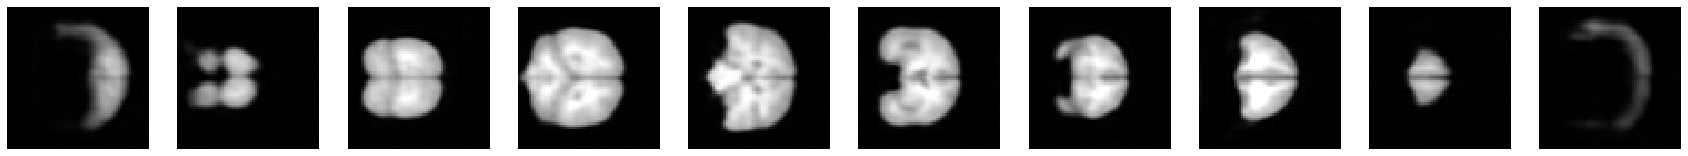

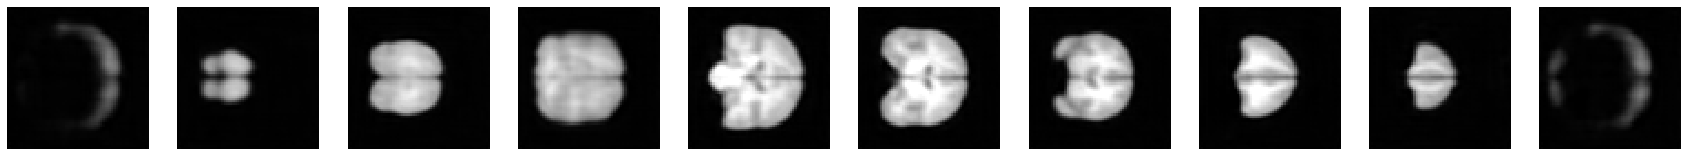

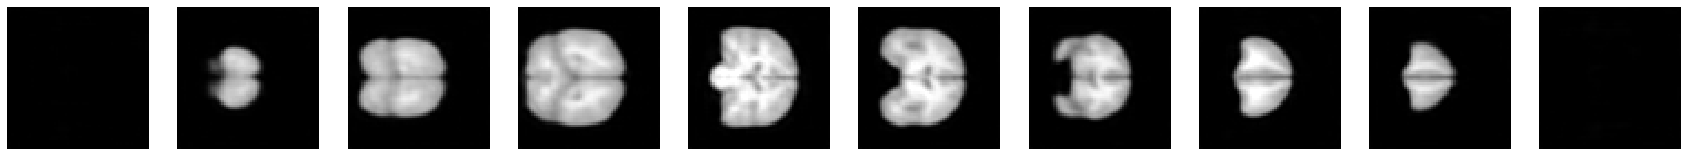

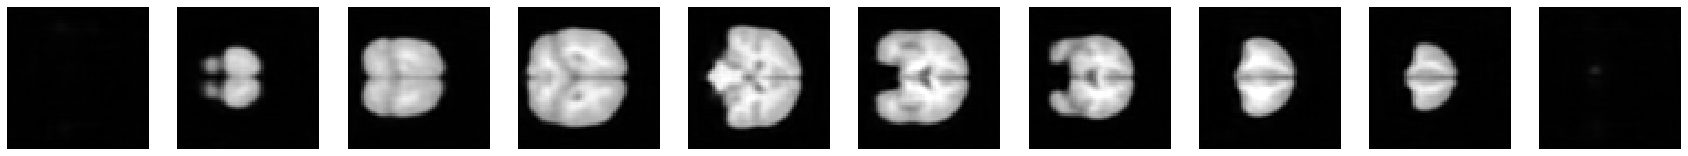

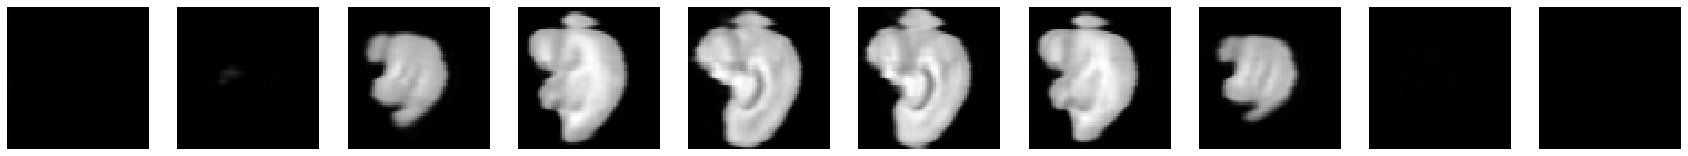

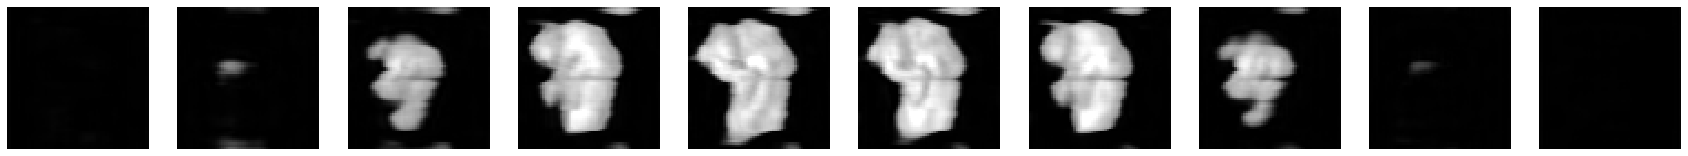

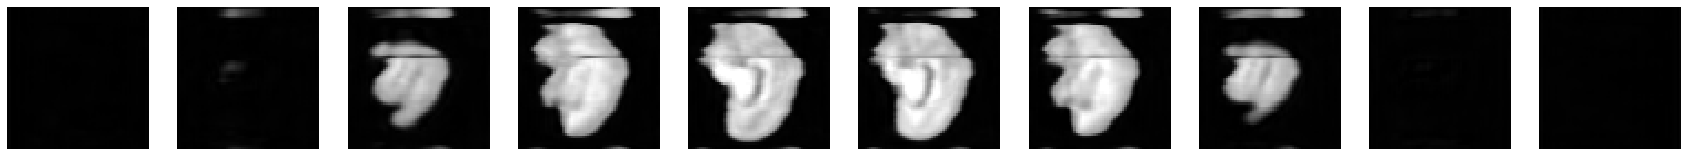

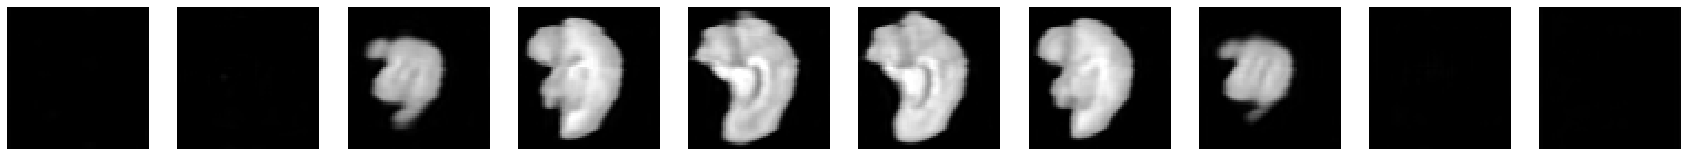

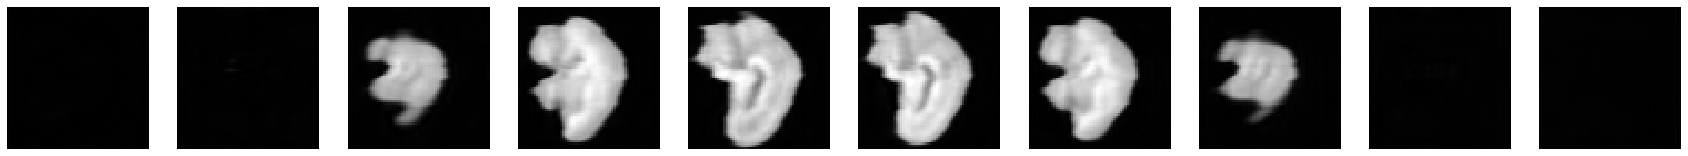

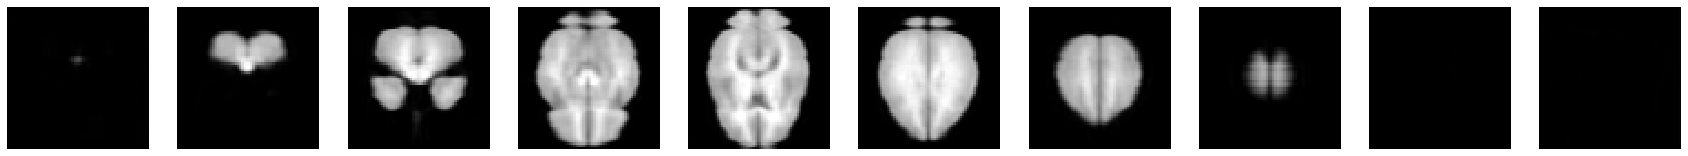

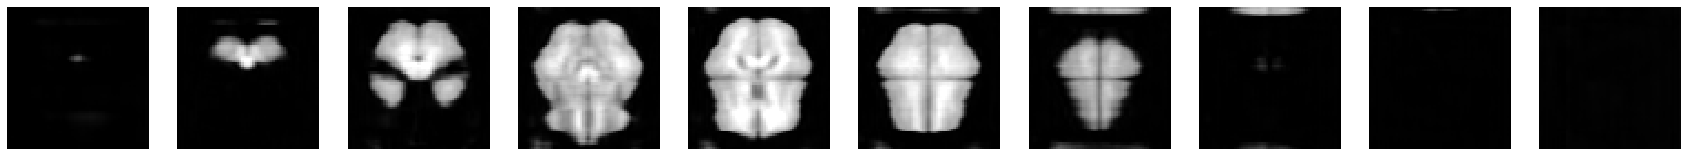

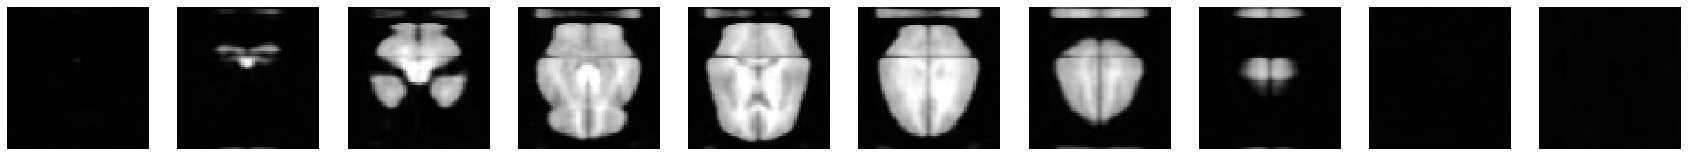

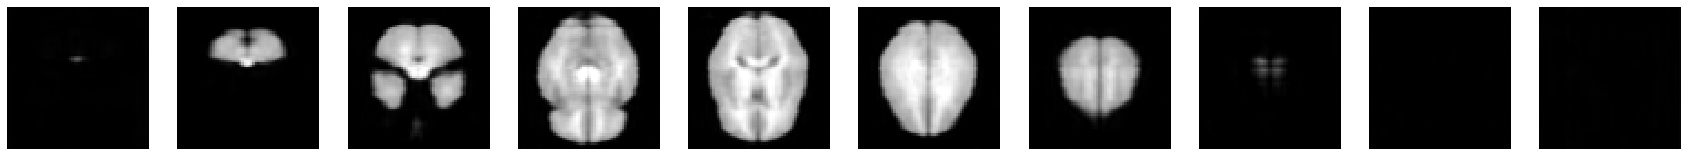

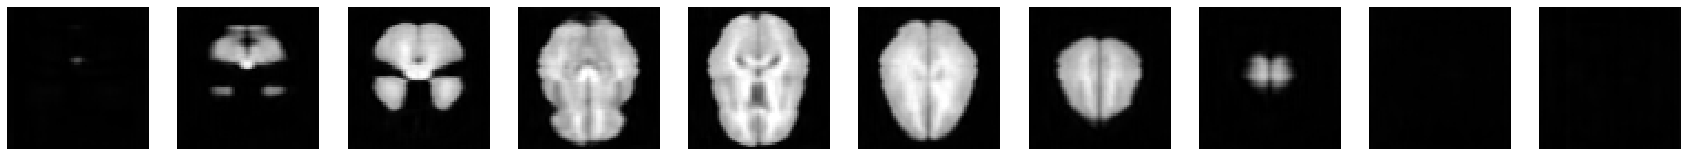

In [15]:
P = 64

observed = (X_test.transpose([0, 2, 1])).transpose([0, 2, 1])

sdiaged = s[:, None, :P]*np.eye(P) / np.sqrt(N_train_ex)
A = np.matmul(vh.transpose([0, 2, 1])[:, :, :P], sdiaged)

z_gt = np.random.randn(latent_dimension*conv_h*conv_w, N_test_ex, P)
observed = (A @ z_gt.transpose([0, 2, 1])).transpose([0, 2, 1])

latent_recon = torch.Tensor(observed) + torch.Tensor(mean)
latent_recon = latent_recon.permute([1, 2, 0])
latent_recon = unflatten_conv_map(latent_recon)

samples = np.zeros(images_test[:, :, None, :, :].shape)

for i in range(5):
    images = decoder(latent_recon[i,...].to(device()))
    samples[i, ...] = images.detach().cpu().numpy()

for i in range(5):
    plot_sequence_coronal(samples[i, ...], K=10)
print('='*80)
for i in range(5):
    plot_sequence_sagittal(samples[i, ...], K=10)
print('='*80)
for i in range(5):
    plot_sequence_axial(samples[i, ...], K=10)



In [16]:
def sample_volumes_minus1_1():
    '''samples volumes. volumes are normalized to be in the -1 to 1 range'''
    z_gt = np.random.randn(latent_dimension*conv_h*conv_w, 1, P)*1
    
    observed = (A @ z_gt.transpose([0, 2, 1])).transpose([0, 2, 1])
    latent_recon = torch.Tensor(observed) + torch.Tensor(mean)
    latent_recon = latent_recon.permute([1, 2, 0])
    latent_recon = unflatten_conv_map(latent_recon)

    images = decoder(latent_recon[0,...].to(device()))
    images[images<0] = 0
    images[images>1] = 1
    images = 2*images -1

    return images.detach().cpu().numpy().squeeze()[None, ...]

In [17]:
np.random.seed(2020)
torch.manual_seed(2020)

# MS-SSIM

You could compute MS-SSIM here on pairs of real-generated images

# MMD

In [2]:
def sample_volumes_8batch():
    z_gt = np.random.randn(latent_dimension*conv_h*conv_w, 8, P)*1

    observed = (A @ z_gt.transpose([0, 2, 1])).transpose([0, 2, 1])
    latent_recon = torch.Tensor(observed) + torch.Tensor(mean)
    latent_recon = latent_recon.permute([1, 2, 0])
    latent_recon = unflatten_conv_map(latent_recon)
    images = torch.zeros(8, 1, 64, 64, 64)
    for i in range(8):
        images[i, 0, ...] = decoder(latent_recon[i,...].to(device())).detach().cpu().squeeze()[None, ...]
    images[images<0] = 0
    images[images>1] = 1
    images = 2*images -1
    return images


You could compute MMD here on batches of 8 images

In [3]:
np.random.seed(2020)
torch.manual_seed(2020)
import nibabel as nib

NameError: name 'np' is not defined

In [ ]:
def sample_volumes():
    '''samples volumes. volumes are normalized to be in the 0 to 1 range'''
    z_gt = np.random.randn(latent_dimension*conv_h*conv_w, 1, P)*1
    
    observed = (A @ z_gt.transpose([0, 2, 1])).transpose([0, 2, 1])
    latent_recon = torch.Tensor(observed) + torch.Tensor(mean)
    latent_recon = latent_recon.permute([1, 2, 0])
    latent_recon = unflatten_conv_map(latent_recon)

    images = decoder(latent_recon[0,...].to(device()))
    images[images<0] = 0
    images[images>1] = 1

    return images.detach().cpu().numpy().squeeze()[None, ...]

In [ ]:
def save_nii(img_path, data, affine, header=None):
    '''
    Shortcut to save a nifty file
    '''
    if header == None:
        nimg = nib.Nifti1Image(data, affine=affine)
    else:
        nimg = nib.Nifti1Image(data, affine=affine, header=header)
    nimg.to_filename(img_path)

In [ ]:
save_dir = 'path/to/saving/volumes/64'
method = 'ours'
methoddir = os.path.join(save_dir, method)
os.makedirs(methoddir, exist_ok=True)
for i in range(100):
    print(i)
    data = sample_volumes().squeeze()
    assert data.min() >= 0.0
    assert data.max() <= 1.0
    img_path = os.path.join(methoddir, 'images_{0:06d}.nii'.format(i))
    save_nii(img_path, data, np.eye(4), header=None)